In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import string
import os.path
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
import matplotlib.patches as mpatches
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
CO28151 = pd.read_excel('../../results/experimental/CO28151_outcome summary-v2.xlsx', 'CO28151')
CO28151.loc[:, 'name'] = CO28151.name.str.strip()

def clean_adj_p(pstr):
    if pstr == '>0,99':
        p = 0.99
    elif pstr == '<0,001':
        p = 0.00099
    else:
        p = np.float64(pstr)
    return(p)

CO28151['Adjusted P Value'] = CO28151['Adjusted P Value'].apply(clean_adj_p)
CO28151['Summary'] = [0 if s == 'ns' else np.sign(fx) * len(s) for s, fx in zip(CO28151['Summary'], CO28151['Mean Diff,'])]
CO28151

,class,assay,assay1,TI,name,Bonferroni's multiple comparisons test,"Mean Diff,","95,00% CI of diff,",Below threshold?,Summary,Adjusted P Value,conc
0,Exp3 Abeta Clearance BV2,Abeta in SN,Abeta celarance supernatant,TI2,Phenamil methanesulfonate salt,VC vs. c1,7889.0000,4674 to 11104,Yes,3.0,0.00099,c1
1,Exp3 Abeta Clearance BV2,Abeta in SN,Abeta celarance supernatant,TI2,Phenamil methanesulfonate salt,VC vs. c2,1328.0000,-1887 to 4543,No,0.0,0.88000,c2
2,Exp3 Abeta Clearance BV2,Abeta in SN,Abeta celarance supernatant,TI2,Phenamil methanesulfonate salt,VC vs. c3,4365.0000,1150 to 7580,Yes,2.0,0.00600,c3
3,Exp3 Abeta Clearance BV2,Abeta in SN,Abeta celarance supernatant,TI3,Benzamil hydrochloride hydrate,VC vs. c1,7398.0000,4830 to 9966,Yes,3.0,0.00099,c1
4,Exp3 Abeta Clearance BV2,Abeta in SN,Abeta celarance supernatant,TI3,Benzamil hydrochloride hydrate,VC vs. c2,6674.0000,4105 to 9242,Yes,3.0,0.00099,c2
...,...,...,...,...,...,...,...,...,...,...,...,...
370,Exp6 LPS Neuroinflamamtion BV2,KC/GRO,LPS inflammation KC/GRO,TI13,Liraglutide,LPS vs. c2,0.5517,"-1,490 to 2,593",No,0.0,0.99000,c2
371,Exp6 LPS Neuroinflamamtion BV2,KC/GRO,LPS inflammation KC/GRO,TI13,Liraglutide,LPS vs. c3,0.2617,"-1,780 to 2,303",No,0.0,0.99000,c3
372,Exp6 LPS Neuroinflamamtion BV2,MTT,LPS inflammation MTT,TI13,Liraglutide,LPS vs. c1,-3.0000,"-14,20 to 8,199",No,0.0,0.99000,c1
373,Exp6 LPS Neuroinflamamtion BV2,MTT,LPS inflammation MTT,TI13,Liraglutide,LPS vs. c2,-6.5000,"-17,70 to 4,699",No,0.0,0.60000,c2


In [3]:
def read_results(fpath='../../results/experimental/cell-based-assays.xlsx', sheet='Sheet2'):
    results = pd.read_excel(fpath, sheet, header=[0, 1, 2])
    results = results.set_index(('class', 'assay', 'concentration'))
    results = results.drop(results.columns[0], axis=1)
    results = results.transpose()
    results = results.rename_axis(['class', 'assay', 'concentration'], axis='index')
    results['conc'] = results.index.get_level_values('concentration')
    results = results.rename(index={'c4': 'c1', 'c5': 'c2', 'c6': 'c3'}, level=2)
    return(results)

#results = read_results()
#results

Tina's email from 6/19/2023:

> Hi Vijay,
There are 2 read-outs where the direction does not necessarily indicate beneficial or detrimental effects, maybe do not include them in the main analysis:
> 
>- Abeta secretion for Ab1-38 it is not that “black and white” as for Ab1-40 and Ab1-42 -> Ab1-38 isoform is > expected to be protective, so an increase would not necessarily be negative, while a decrease can also indicate generally lower Abeta load.
>- Tau phosphorylation - total Tau a change in either direction can have beneficial effects, the most relevant read-out in this assay is tau phosphorylation as well as the ratio.
> 
>All others are correct.
> 
>Best,
Tina

Following this email I drop Abeta1-38 and total Tau from the assays.

In [4]:
d = {
    '***↑': 3,
    '**↑': 2,
    '*↑': 1,
    'ns': 0,
    '*↓': -1,
    '**↓': -2,
    '***↓': -3,
    'not performed': 9,
}

fpath = '../../resources/cell-based-assays/CO25360_Overview results_all.xlsx'
df = pd.read_excel(fpath, 'Tabelle1', skiprows=5, index_col=[2, 3], header=list(range(3)))
df = df.drop(df.columns[0:2], axis=1)
df = pd.DataFrame([pd.Categorical(df[n], categories=d.keys()).rename_categories(d) for n in df], index=df.index, columns=df.columns)
df = df.applymap(lambda x: np.nan if x == 9 else x)
fpath = fpath.replace('.xlsx', '-clean.xlsx')
df.to_excel(fpath, 'Sheet1')
# Manually edited Excel doc and saved it as the fpath below
# 1: remove empty first row (a bug of ExcelWriter with multilevel columns)
# 2: label index levels as class, assay, concentration
fpath = '../../resources/cell-based-assays/CO25360_Overview results_all-clean1.xlsx'
results_1 = read_results(fpath, 'Sheet1')
fpath = '../../resources/cell-based-assays/treatment-names.csv'
results_1 = results_1.rename(pd.read_csv(fpath, index_col=0).squeeze().to_dict(), axis=1)
assays_to_drop = ['total Tau', 'Ab1-38']
results_1 = results_1.drop(assays_to_drop, axis=0, level=1)
results_1

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_77181/1422347880.py:15: FutureWarning: The behavior of DataFrame([categorical, ...]) is deprecated and in a future version will be changed to match the behavior of DataFrame([any_listlike, ...]). To retain the old behavior, pass as a dictionary DataFrame({col: categorical, ..})
  df = pd.DataFrame([pd.Categorical(df[n], categories=d.keys()).rename_categories(d) for n in df], index=df.index, columns=df.columns)


('class', 'assay', 'concentration')                                                Valproic acid  \
class                                          assay                concentration                  
Exp2 Abeta induced toxicity primary neurons    MTT (viability)      c1                       0.0   
                                                                    c2                       0.0   
                                                                    c3                       0.0   
Exp3 Abeta Clearance BV2                       Abeta in SN          c1                       0.0   
                                                                    c2                       1.0   
...                                                                                          ...   
Exp8 trophic factor withdrawal primary neurons LDH (cell death)     c2                       0.0   
                                                                    c3                       0.0   
Exp9 Tau Agg cell-free                         Tau aggregation ΔRFU c1                       0.0   
                                                                    c2                       0.0   
                                                                    c3                      -2.0   

('class', 'assay', 'concentration')                                                Salbutamol  \
class                                          assay                concentration               
Exp2 Abeta induced toxicity primary neurons    MTT (viability)      c1                    0.0   
                                                                    c2                    0.0   
                                                                    c3                    0.0   
Exp3 Abeta Clearance BV2                       Abeta in SN          c1                    0.0   
                                                                    c2                    0.0   
...                                                                                       ...   
Exp8 trophic factor withdrawal primary neurons LDH (cell death)     c2                    0.0   
                                                                    c3                    0.0   
Exp9 Tau Agg cell-free                         Tau aggregation ΔRFU c1                    0.0   
                                                                    c2                    0.0   
                                                                    c3                    0.0   

('class', 'assay', 'concentration')                                                Sildenafil  \
class                                          assay                concentration               
Exp2 Abeta induced toxicity primary neurons    MTT (viability)      c1                    0.0   
                                                                    c2                    0.0   
                                                                    c3                    0.0   
Exp3 Abeta Clearance BV2                       Abeta in SN          c1                    0.0   
                                                                    c2                    0.0   
...                                                                                       ...   
Exp8 trophic factor withdrawal primary neurons LDH (cell death)     c2                    0.0   
                                                                    c3                    0.0   
Exp9 Tau Agg cell-free                         Tau aggregation ΔRFU c1                    0.0   
                                                                    c2                    0.0   
                                                                    c3                   -1.0   

('class', 'assay', 'concentration')                                                Probenecid  \
class                                          assay                concentrat

In [5]:
results_CO28151 = CO28151.pivot(index=['class', 'assay', 'conc'], columns='name', values='Summary')
results_CO28151
#results_1 = read_results(sheet='Sheet3')
results_all = pd.concat([results_1, results_CO28151], axis=1)
results_all

Valproic acid  \
class                                          assay                                    
Exp2 Abeta induced toxicity primary neurons    MTT (viability)      c1            0.0   
                                                                    c2            0.0   
                                                                    c3            0.0   
Exp3 Abeta Clearance BV2                       Abeta in SN          c1            0.0   
                                                                    c2            1.0   
...                                                                               ...   
Exp8 trophic factor withdrawal primary neurons LDH (cell death)     c2            0.0   
                                                                    c3            0.0   
Exp9 Tau Agg cell-free                         Tau aggregation ΔRFU c1            0.0   
                                                                    c2            0.0   
                                                                    c3           -2.0   

                                                                        Salbutamol  \
class                                          assay                                 
Exp2 Abeta induced toxicity primary neurons    MTT (viability)      c1         0.0   
                                                                    c2         0.0   
                                                                    c3         0.0   
Exp3 Abeta Clearance BV2                       Abeta in SN          c1         0.0   
                                                                    c2         0.0   
...                                                                            ...   
Exp8 trophic factor withdrawal primary neurons LDH (cell death)     c2         0.0   
                                                                    c3         0.0   
Exp9 Tau Agg cell-free                         Tau aggregation ΔRFU c1         0.0   
                                                                    c2         0.0   
                                                                    c3         0.0   

                                                                        Sildenafil  \
class                                          assay                                 
Exp2 Abeta induced toxicity primary neurons    MTT (viability)      c1         0.0   
                                                                    c2         0.0   
                                                                    c3         0.0   
Exp3 Abeta Clearance BV2                       Abeta in SN          c1         0.0   
                                                                    c2         0.0   
...                                                                            ...   
Exp8 trophic factor withdrawal primary neurons LDH (cell death)     c2         0.0   
                                                                    c3         0.0   
Exp9 Tau Agg cell-free                         Tau aggregation ΔRFU c1         0.0   
                                                                    c2         0.0   
                                                                    c3        -1.0   

                                                                        Probenecid  \
class                                          assay                                 
Exp2 Abeta induced toxicity primary neurons    MTT (viability)      c1         0.0   
                                                                    c2         0.0   
                                                                    c3         0.0   
Exp3 Abeta Clearance BV2                       Abeta in SN          c1         0.0   
                                                                    c2        -1.0   
...                                                                       

In [6]:
sel_drugs = ['Chenodiol', 'Cysteamine HCl', 'Arundine', 'C-DIM12', 'DIM-C-pPhOCH3']
results = results_all.loc[:, sel_drugs + ['conc']]
results = results.rename({'Cysteamine HCl': 'Cysteamine'}, axis=1)
results

Chenodiol  \
class                                          assay                                
Exp2 Abeta induced toxicity primary neurons    MTT (viability)      c1        0.0   
                                                                    c2        0.0   
                                                                    c3        0.0   
Exp3 Abeta Clearance BV2                       Abeta in SN          c1        0.0   
                                                                    c2        0.0   
...                                                                           ...   
Exp8 trophic factor withdrawal primary neurons LDH (cell death)     c2        0.0   
                                                                    c3        0.0   
Exp9 Tau Agg cell-free                         Tau aggregation ΔRFU c1        NaN   
                                                                    c2        NaN   
                                                                    c3        NaN   

                                                                        Cysteamine  \
class                                          assay                                 
Exp2 Abeta induced toxicity primary neurons    MTT (viability)      c1         0.0   
                                                                    c2         0.0   
                                                                    c3         0.0   
Exp3 Abeta Clearance BV2                       Abeta in SN          c1         0.0   
                                                                    c2         1.0   
...                                                                            ...   
Exp8 trophic factor withdrawal primary neurons LDH (cell death)     c2         0.0   
                                                                    c3         0.0   
Exp9 Tau Agg cell-free                         Tau aggregation ΔRFU c1         NaN   
                                                                    c2         NaN   
                                                                    c3         NaN   

                                                                        Arundine  \
class                                          assay                               
Exp2 Abeta induced toxicity primary neurons    MTT (viability)      c1       0.0   
                                                                    c2       0.0   
                                                                    c3       0.0   
Exp3 Abeta Clearance BV2                       Abeta in SN          c1       0.0   
                                                                    c2      -1.0   
...                                                                          ...   
Exp8 trophic factor withdrawal primary neurons LDH (cell death)     c2       0.0   
                                                                    c3       0.0   
Exp9 Tau Agg cell-free                         Tau aggregation ΔRFU c1       NaN   
                                                                    c2       NaN   
                                                                    c3       NaN   

                                                                        C-DIM12  \
class                                          assay                              
Exp2 Abeta induced toxicity primary neurons    MTT (viability)      c1      NaN   
                                                                    c2      NaN   
                                                                    c3      NaN   
Exp3 Abeta Clearance BV2                       Abeta in SN          c1      0.0   
                                                                    c2      0.0   
...                                                                         ...   
Exp8 trophic factor withdrawal primary neurons LDH (cell death)     c2      0.0   
       

In [7]:
#results = results.dropna(axis=0)
results.loc[:, 'class'] = pd.Categorical(results.index.get_level_values('class'))
new_class_names = [r'A$\beta$ induced toxicity', r'A$\beta$ clearance', r'A$\beta$ secretion', 'Tau phosphorylation', 'LPS neuroinflammation', 'Neurogenesis, neurite outgrowth', 'Trophic factor withdrawal']
new_class_names = [X + ')  ' + c for X, c in zip(list(string.ascii_uppercase)[:len(new_class_names)], new_class_names)]
mapper = dict(zip(results['class'].cat.categories, new_class_names))
results = results.drop('class', axis=1)
results = results.rename(mapper, axis=0, level=0)
results = results.drop('Tau aggregation ΔRFU', axis=0, level=1)
results#.dropna()

Chenodiol  Cysteamine  \
class                         assay                                        
A)  A$\beta$ induced toxicity MTT (viability)  c1        0.0         0.0   
                                               c2        0.0         0.0   
                                               c3        0.0         0.0   
B)  A$\beta$ clearance        Abeta in SN      c1        0.0         0.0   
                                               c2        0.0         1.0   
...                                                      ...         ...   
G)  Trophic factor withdrawal MTT (viability)  c2        0.0        -2.0   
                                               c3        0.0        -1.0   
                              LDH (cell death) c1        3.0         0.0   
                                               c2        0.0         0.0   
                                               c3        0.0         0.0   

                                                   Arundine  C-DIM12  \
class                         assay                                    
A)  A$\beta$ induced toxicity MTT (viability)  c1       0.0      NaN   
                                               c2       0.0      NaN   
                                               c3       0.0      NaN   
B)  A$\beta$ clearance        Abeta in SN      c1       0.0      0.0   
                                               c2      -1.0      0.0   
...                                                     ...      ...   
G)  Trophic factor withdrawal MTT (viability)  c2       0.0      0.0   
                                               c3       0.0      0.0   
                              LDH (cell death) c1       0.0     -3.0   
                                               c2       0.0      0.0   
                                               c3       0.0      0.0   

                                                   DIM-C-pPhOCH3 conc  
class                         assay                                    
A)  A$\beta$ induced toxicity MTT (viability)  c1            NaN   c1  
                                               c2            NaN   c2  
                                               c3            NaN   c3  
B)  A$\beta$ clearance        Abeta in SN      c1            0.0   c4  
                                               c2            0.0   c5  
...                                                          ...  ...  
G)  Trophic factor withdrawal MTT (viability)  c2            3.0   c2  
                                               c3            0.0   c3  
                              LDH (cell death) c1            0.0   c1  
                                               c2           -2.0   c2  
                                               c3            0.0   c3  

[66 rows x 6 columns]

Ideal effect is the direction of effect of an ideal, hypothetical, neuroprotective drug on a given assay.

In [8]:
fpath = '../../results/2022-09-21-cell-based-assays/protect_sign.csv'
if os.path.exists(fpath):
    protect_sign = pd.read_csv(fpath, index_col=['class', 'assay', 'concentration']).squeeze()
else:
    protect_sign = pd.Series(0, index=results.index, dtype='int8')
    protect_sign.to_csv(fpath)

colname = 'ideal effect: increase (1) or decrease (-1)'
protect_supp_tab = protect_sign.groupby(axis=0, level=['class', 'assay']).first().to_frame(colname)
protect_supp_tab.to_csv('../../results/2022-09-21-cell-based-assays/protect_supp_tab.csv')
#protect_supp_tab = protect_supp_tab.drop(r'A)  A$\beta$ induced toxicity', axis=0, level=0)
protect_supp_tab

ideal effect: increase (1) or decrease (-1)
class                               assay                                                               
A)  A$\beta$ induced toxicity       MTT (viability)                                                    1
B)  A$\beta$ clearance              Abeta in Lysate                                                    1
                                    Abeta in SN                                                       -1
                                    ratio                                                             -1
C)  A$\beta$ secretion              Ab1-40                                                            -1
                                    Ab1-42                                                            -1
D)  Tau phosphorylation             pTau231                                                           -1
                                    ratio                                                             -1
E)  LPS neuroinflammation           IL-10                                                             -1
                                    IL-1b                                                             -1
                                    IL-6                                                              -1
                                    KC/GRO                                                            -1
                                    MTT                                                                1
                                    TNF-a                                                             -1
F)  Neurogenesis, neurite outgrowth BrdU positive neurons                                              1
                                    average longest neurite                                            1
                                    number of branches                                                 1
                                    total neurite area                                                 1
G)  Trophic factor withdrawal       LDH (cell death)                                                  -1
                                    MTT (viability)                                                    1
                                    PI (cell death)                                                   -1
                                    YOPRO (apoptosis)                                                 -1

In [9]:
def results2protective(results, protect_sign=protect_sign):
    results_protect = results.drop('conc', axis=1).apply(lambda col: col * protect_sign.to_list(), axis=0)
    results_protect['conc'] = results.conc
    return(results_protect)

results_protect = results2protective(results, protect_sign=protect_sign)
results_protect

Chenodiol  Cysteamine  \
class                         assay                                        
A)  A$\beta$ induced toxicity MTT (viability)  c1        0.0         0.0   
                                               c2        0.0         0.0   
                                               c3        0.0         0.0   
B)  A$\beta$ clearance        Abeta in SN      c1       -0.0        -0.0   
                                               c2       -0.0        -1.0   
...                                                      ...         ...   
G)  Trophic factor withdrawal MTT (viability)  c2        0.0        -2.0   
                                               c3        0.0        -1.0   
                              LDH (cell death) c1       -3.0        -0.0   
                                               c2       -0.0        -0.0   
                                               c3       -0.0        -0.0   

                                                   Arundine  C-DIM12  \
class                         assay                                    
A)  A$\beta$ induced toxicity MTT (viability)  c1       0.0      NaN   
                                               c2       0.0      NaN   
                                               c3       0.0      NaN   
B)  A$\beta$ clearance        Abeta in SN      c1      -0.0     -0.0   
                                               c2       1.0     -0.0   
...                                                     ...      ...   
G)  Trophic factor withdrawal MTT (viability)  c2       0.0      0.0   
                                               c3       0.0      0.0   
                              LDH (cell death) c1      -0.0      3.0   
                                               c2      -0.0     -0.0   
                                               c3      -0.0     -0.0   

                                                   DIM-C-pPhOCH3 conc  
class                         assay                                    
A)  A$\beta$ induced toxicity MTT (viability)  c1            NaN   c1  
                                               c2            NaN   c2  
                                               c3            NaN   c3  
B)  A$\beta$ clearance        Abeta in SN      c1           -0.0   c4  
                                               c2           -0.0   c5  
...                                                          ...  ...  
G)  Trophic factor withdrawal MTT (viability)  c2            3.0   c2  
                                               c3            0.0   c3  
                              LDH (cell death) c1           -0.0   c1  
                                               c2            2.0   c2  
                                               c3           -0.0   c3  

[66 rows x 6 columns]

In [10]:
plt.rcParams['figure.facecolor'] = 'lightgray'

In [11]:
gb_class = results.groupby('class')
assays_per_class = {name: len(df) / 3 for name, df in gb_class}
assays_per_class

{'A)  A$\\beta$ induced toxicity': 1.0,
 'B)  A$\\beta$ clearance': 3.0,
 'C)  A$\\beta$ secretion': 2.0,
 'D)  Tau phosphorylation': 2.0,
 'E)  LPS neuroinflammation': 6.0,
 'F)  Neurogenesis, neurite outgrowth': 4.0,
 'G)  Trophic factor withdrawal': 4.0}

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (5).

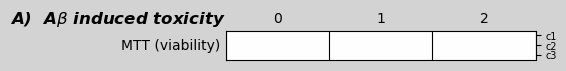

In [12]:
anonymizer = {
    'Chenodiol': 'drug A',
    'Cysteamine': 'drug B',
    'Arundine': 'drug C',
    'conc': 'conc'
}

def process_class(classname, classdata, i, fig, my_cmap, vmin, vmax, results=results):
    n_assays = int(len(classdata) / 3)
    first_assay_name = classdata.index.get_level_values('assay')[0]
    outer_grid = gridspec.GridSpec(len(gb_class), 1, height_ratios = list(assays_per_class.values()), figure=fig, hspace=0.5) 
    inner_gs = gridspec.GridSpecFromSubplotSpec(n_assays, 1, subplot_spec=outer_grid[i], hspace=0.25)
    gb_assay = classdata.groupby('assay')
    for j, zipitem in enumerate(zip(inner_gs, gb_assay)):
        cell, gbitem = zipitem
        ax = plt.subplot(cell)
        assay_name, assay_data = gbitem
        plot_assay(ax, assay_name, assay_data, my_cmap, vmin, vmax)
        ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False, length=0, which='both', axis='x')
        if j == 0:
            ax.set_title(classname, loc='left', y=0.95, horizontalalignment='right', fontstyle='italic', fontweight='bold')
            ax.set_xticks(range(3))
            ax.set_xticklabels(results.columns[:-1], fontsize=12)#, rotation=-45, horizontalalignment='left')
            ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False, length=10, which='minor')
    return(ax)

def plot_assay(axi, assay_name, assay_data, my_cmap, vmin, vmax):
        axi.imshow(assay_data.iloc[:, range(3)], aspect='auto', interpolation='none', cmap=my_cmap, vmin=vmin, vmax=vmax)
        axi.set_xticks(range(3))
        axi.set_yticks(range(assay_data.shape[0]))
        axi.set_yticklabels(assay_data.conc, fontsize=7)
        axi.set_ylabel(assay_name, rotation=0, verticalalignment='center', horizontalalignment='right')
        axi.tick_params(right=True, left=False, labelright=True, labelleft=False)
        axi.set_xticks([])
        axi.set_xticks(np.arange(4) - 0.5, minor=True)
        axi.grid(axis='x', which='minor', color='black')
        return(axi)

projector = {3: 1, 2: 1, 1: 1, 0: 0, -1: -1, -2: -1, -3: -3}
def simplify_results(results, projector=projector):
    val = results.drop('conc', axis=1).applymap(lambda x: projector[x] if not pd.isna(x) else x)
    val['conc'] = results.conc
    return(val)

def my_figure(protective=False, simplify=False, protective_cmap='RdYlGn', anonymize=False):
    res = results_protect if protective else results
    res = res.rename(anonymizer, axis=1) if anonymize else res
    res = simplify_results(res) if simplify else res
    gb_class = res.groupby('class')
    cmap = protective_cmap if protective else 'bwr_r'
    #cmap = 'PiYG' if protective else 'bwr_r'
    n_levels = 3 if simplify else 7
    my_cmap = matplotlib.colors.ListedColormap(matplotlib.colormaps[cmap](np.linspace(0, 1, n_levels)))
    vmin = -1.5 if simplify else -3.5
    vmax = 1.5 if simplify else 3.5
    fig = plt.figure(figsize=(4, 12))
    for i, classinfo in enumerate(gb_class):
        classname, classdata = classinfo
        axi = process_class(classname, classdata, i, fig, my_cmap=my_cmap, vmin=vmin, vmax=vmax, results=res)
    #my_patch = mpatches.Patch(color='green', alpha=0.5, label='TWAS2+ gene set')
    cb_ax = fig.add_axes([-0.7, 0.675, 0.05, 0.20])
    cm = plt.cm.ScalarMappable(cmap=my_cmap)
    cm.set_clim(vmin=vmin, vmax=vmax)
    fig.colorbar(cm, cax=cb_ax)
    cb_ax.set_yticks(np.arange(-1 if simplify else -3, 2 if simplify else 4, 1))
    ticklab_abs = [r'$\downarrow$', r'n.s', r'$\uparrow$'] if simplify else [r'$\downarrow$***', r'$\downarrow$**', r'$\downarrow$*', r'n.s', r'$\uparrow$*', r'$\uparrow$**', r'$\uparrow$***']
    ticklab_prot = [r'adverse', r'n.s', r'protective'] if simplify else [r'*** adverse', r'**', r'*', r'n.s', r'*', r'**', r'*** protective']
    cb_ax.set_yticklabels(ticklab_prot if protective else ticklab_abs)
    cb_ax.set_title('drug effect')
    return(fig)

fig = my_figure(protective=False)
fig
attila_utils.savefig(fig, 'cell-based-assays-absolute')

In [ ]:
fig = my_figure(protective=True)
fig
attila_utils.savefig(fig, 'cell-based-assays')

In [ ]:
fig = my_figure(protective=True, simplify=True)
fig
attila_utils.savefig(fig, 'cell-based-assays-simplified')

In [ ]:
fig = my_figure(protective=True, simplify=True, anonymize=True)
fig
attila_utils.savefig(fig, 'cell-based-assays-simplified-anonimized')

## All results

In [ ]:
CO28151 = pd.read_excel('../../results/experimental/CO28151_outcome summary-v2.xlsx', 'CO28151')
CO28151.loc[:, 'name'] = CO28151.name.str.strip()

def clean_adj_p(pstr):
    if pstr == '>0,99':
        p = 0.99
    elif pstr == '<0,001':
        p = 0.00099
    else:
        p = np.float64(pstr)
    return(p)

CO28151['Adjusted P Value'] = CO28151['Adjusted P Value'].apply(clean_adj_p)
CO28151['Summary'] = [0 if s == 'ns' else np.sign(fx) * len(s) for s, fx in zip(CO28151['Summary'], CO28151['Mean Diff,'])]
CO28151

We see that `results_1` contains 75 / 3 = 25 assays and 

In [ ]:
d = {'results_1': results_1, 'results_CO28151': results_CO28151}
print('Number of assays:')
print({k: np.int64(df.shape[0] / 3) for k, df in d.items()})
print('Number of drugs:')
print({k: np.int64(df.shape[1]) for k, df in d.items()})

In [ ]:
fpath_1 = '../../results/2022-09-21-cell-based-assays/protect_sign_1.csv'
protect_sign_1 = pd.read_csv(fpath_1, index_col=['class', 'assay', 'concentration']).squeeze()
results_all_protect = results2protective(results_all, protect_sign=protect_sign_1)
results_all_protect

In [ ]:
agg_assay = results_all_protect.groupby(axis=0, level=1, sort=False).mean().transpose()
agg_assay
agg_experiment = results_all_protect.groupby(axis=0, level=0, sort=False).mean().transpose()
agg_experiment

In [ ]:
def my_heatmap(df):
    fig, ax = plt.subplots()
    im = ax.imshow(X=df,cmap='RdYlGn')
    cbar = ax.figure.colorbar(im, ax=ax, orientation='vertical')
    ax_cbar = fig.get_axes()[1]
    ax_cbar.set_ylabel('Neuroprotectivity')
    ax.set_xticks(np.arange(len(df.columns)))
    fontsize = 6
    #ax.tick_params(which='minor', length=0)
    ax.set_xticks(np.arange(len(df.columns)) - 0.5, minor=True)
    ax.set_xticklabels(df.columns, rotation=90, fontsize=fontsize)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(df.index, fontsize=fontsize)
    ax.set_yticks(np.arange(len(df.index)) - 0.5, minor=True)
    ax.grid(which='minor', color="w", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.spines[:].set_visible(False)
    return((fig, ax))

In [ ]:
fig, ax = my_heatmap(agg_assay)
attila_utils.savefig(fig, 'heatmap-agg-assay')

In [ ]:
fig, ax = my_heatmap(agg_experiment)
attila_utils.savefig(fig, 'heatmap-agg-experiment')

In [ ]:
{c: i for c, i in zip(agg_experiment.columns, np.arange(agg_experiment.shape[1]))}

In [ ]:
def score_drugs(aggdf, ix=[1, 2, 4], weights=[1, 1, 1]):
    df = aggdf.iloc[:, ix]
    weights = [w / sum(weights) * 3 for w in weights]
    l = [w * df[s] for s, w in zip(df, weights)]
    df = pd.concat(l, axis=1)
    s = df.sum(1)
    s = s.sort_values(ascending=False)
    return(s)

scores_experiment = score_drugs(agg_experiment)
scores_experiment

In [ ]:
fig, ax = plt.subplots(figsize=(4, 8))
scores_experiment.iloc[::-1].plot(kind='barh', ax=ax)
ax.set_title('Ranked drugs')
ax.set_xlabel(r'avg. $\log_{10} p$')
attila_utils.savefig(fig, 'ranked-drugs')

In [ ]:
%connect_info